In [1]:
"""State space model in PyMC"""
import numpy as np
import matplotlib.pyplot as plt

import aeppl
import aesara
import aesara.tensor as at

import pymc as pm
import arviz as az

srng = at.random.RandomStream(seed=0)

# Example code

In [2]:
sigma_rv = at.random.halfnormal(0, 5.0, name="sigma")
mu_rv = at.random.normal(0, 1.0, name="mu")


def step(x_tm1, sigma_rv):
    x = at.random.normal(x_tm1, sigma_rv)
    return x  # , {x.owner.inputs[0]: x.owner.outputs[0]}


scan_rv, updates = aesara.scan(
    fn=step,
    outputs_info=[{"initial": mu_rv}],
    n_steps=100,
    non_sequences=[sigma_rv],
    # strict=True,
)
scan_rv.name = "scan"

sigma_vv = sigma_rv.clone()
mu_vv = mu_rv.clone()
scan_vv = scan_rv.clone()

aeppl.factorized_joint_logprob(
    {
        sigma_rv: sigma_vv,
        mu_rv: mu_vv,
        scan_rv: scan_vv,
    }
)

{sigma: sigma_logprob, mu: mu_logprob, scan: scan_logprob}

In [3]:
require_inner_rewrites = True

N_tt = at.iscalar("N")
M_tt = at.iscalar("M")
mus_tt = at.matrix("mus_t")

sigmas_tt = at.ones((N_tt,))
Gamma_rv = srng.dirichlet(at.ones((M_tt, M_tt)), name="Gamma")


def scan_fn(mus_t, sigma_t, Gamma_t):
    S_t = srng.categorical(Gamma_t[0], name="S_t")

    if require_inner_rewrites:
        Y_t = srng.normal(mus_t, sigma_t, name="Y_t")[S_t]
    else:
        Y_t = srng.normal(mus_t[S_t], sigma_t, name="Y_t")

    return Y_t, S_t


(Y_rv, S_rv), _ = aesara.scan(
    fn=scan_fn,
    sequences=[mus_tt, sigmas_tt],
    non_sequences=[Gamma_rv],
    outputs_info=[{}, {}],
    # strict=True,
    name="scan_rv",
)
# Y_rv.name = "Y"
# S_rv.name = "S"

y_vv = Y_rv.clone()
y_vv.name = "y"

s_vv = S_rv.clone()
s_vv.name = "s"

Gamma_vv = Gamma_rv.clone()
Gamma_vv.name = "Gamma_vv"

aeppl.factorized_joint_logprob({Y_rv: y_vv, S_rv: s_vv, Gamma_rv: Gamma_vv})

{Gamma_vv: Gamma_vv_logprob, y: y_logprob, s: s_logprob}

In [4]:
y_logp = aeppl.joint_logprob({Y_rv: y_vv, S_rv: s_vv, Gamma_rv: Gamma_vv})

y_val = np.arange(10)
s_val = np.array([0, 1, 0, 1, 1, 0, 0, 0, 1, 1])

N_val = 10
# N_tt.tag.test_value = N_val
M_val = 2
# M_tt.tag.test_value = M_val
mus_val = np.stack([np.arange(0.0, 10), np.arange(0.0, -10, -1)], axis=-1).astype(
    aesara.config.floatX
)
# mus_tt.tag.test_value = mus_val
Gamma_val = np.array([[0.5, 0.5], [0.5, 0.5]])
# Gamma_rv.tag.test_value = Gamma_val

test_point = {
    y_vv: y_val,
    s_vv: s_val,
    M_tt: M_val,
    N_tt: N_val,
    mus_tt: mus_val,
    Gamma_vv: Gamma_val,
}

y_logp_fn = aesara.function(list(test_point.keys()), y_logp)
y_logp_fn(*test_point.values())

array(-358.12085714)

# State space model

In [5]:
def transition(x_tm1, Ft, Qt):
    return srng.multivariate_normal(Ft @ x_tm1, Qt, name="x_t")


def observation(x_t, Ht, Rt):
    return srng.multivariate_normal(Ht @ x_t, Rt, name="y_t")


def state_space_onestep(x_tm1, Ft, Qt, Ht, Rt):
    x_t = transition(x_tm1, Ft, Qt)
    y_t = observation(x_t, Ht, Rt)
    return y_t, x_t

In [6]:
# F = at.matrix("F")  # Transition matrix
# Q = at.matrix("Q")  # Transition noise covariance
# H = at.matrix("H")  # Observation matrix
# R = at.matrix("R")  # Observation noise covariance

# # mu0 = at.vector("mu0")  # Initial state mean
# # sigma0 = at.matrix("sigma0")  # Initial state covariance
# # x0 = srng.multivariate_normal(mu0, sigma0, name="x0")  # Initial state
# x0 = at.vector("x0")  # Initial state

# def step(_, x_tm1, Ft, Qt, Ht, Rt):
#     x_t = srng.multivariate_normal(Ft @ x_tm1, Qt, name="x_t")
#     y_t = srng.multivariate_normal(Ht @ x_t, Rt, name="y_t")
#     return y_t, x_t

# (y_rv, x_rv), updates = aesara.scan(
#     fn=step,
#     # outputs_info=[at.constant(np.zeros([2])), x0],
#     outputs_info=[at.constant(np.zeros([2])), x0],
#     n_steps=100,
#     non_sequences=[F, Q, H, R],
#     # strict=True,
# )
# y_rv.name = "y_rv"
# x_rv.name = "x_rv"

# y_vv = y_rv.clone()
# y_vv.name = "y_vv"
# x_vv = x_rv.clone()
# x_vv.name = "x_vv"

# aeppl.factorized_joint_logprob({
#     y_rv: y_vv,
#     x_rv: x_vv,
# })

## Recursive linear regression as a state space model

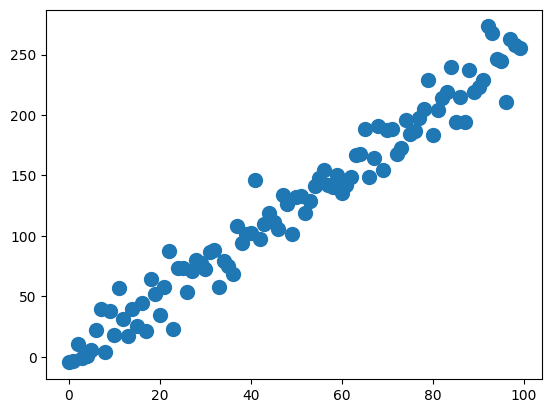

In [7]:
theta0, theta1 = 1.2, 2.6
sigma_true = 15.0
num_timesteps = 100

x = np.linspace(0.0, num_timesteps - 1, num_timesteps)[..., None]
yhat = theta0 + theta1 * x

# y ∼ Normal(yhat, σ^2)
y = np.random.normal(yhat, sigma_true)
_, ax = plt.subplots()
ax.scatter(x, y, 100);

In [8]:
# Analytic solution
m0 = np.zeros([2])
P0 = np.eye(2) * 10.0

P0_inv = np.linalg.inv(P0)
H_np = np.concatenate([np.ones_like(x), x], axis=-1)
P_t = np.linalg.inv(P0_inv + 1 / sigma_true**2 * (np.matmul(H_np.T, H_np)))
m_t = np.matmul(
    P_t, (1 / sigma_true**2 * np.matmul(H_np.T, y) + np.matmul(P0_inv, m0[..., None]))
)

In [9]:
F = at.matrix("F")  # Transition matrix
Q = at.matrix("Q")  # Transition noise covariance
H = at.matrix("H")  # Observation matrix
R = at.matrix("R")  # Observation noise covariance

mu0 = at.vector("mu0")  # Initial state mean
sigma0 = at.matrix("sigma0")  # Initial state covariance
x0 = srng.multivariate_normal(mu0, sigma0, name="x0")  # Initial state

num_step = at.iscalar("num_step")  # Number of steps

# scan over time
(Y_rv, X_rv), updates = aesara.scan(
    fn=state_space_onestep,
    non_sequences=[F, Q, H, R],
    outputs_info=[None, x0],
    n_steps=num_step,
    # strict=True,
    name="scan_rv",
)
Y_rv.name = "Y_rv"
X_rv.name = "X_rv"

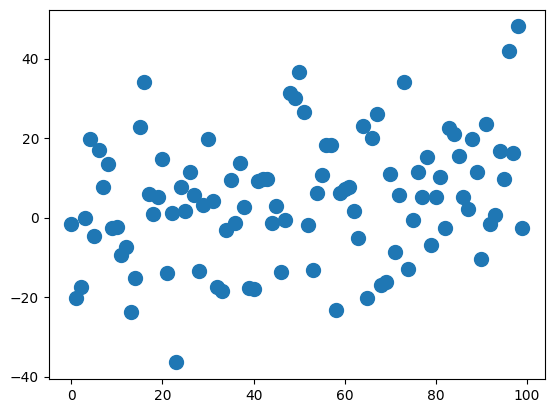

In [10]:
sample_fn = aesara.function((F, Q, H, R, mu0, sigma0, num_step), (Y_rv, X_rv), updates=updates)

y_val, x_val = sample_fn(
    np.asarray([[1.0, 1.0], [0.0, 1.0]]),
    np.zeros([2, 2]),
    np.asarray([[1.0, 0.0]]),
    np.asarray([[sigma_true**2]]),
    np.zeros([2]),
    np.eye(2),
    num_timesteps,
)
_, ax = plt.subplots()
ax.scatter(x, y_val, 100);

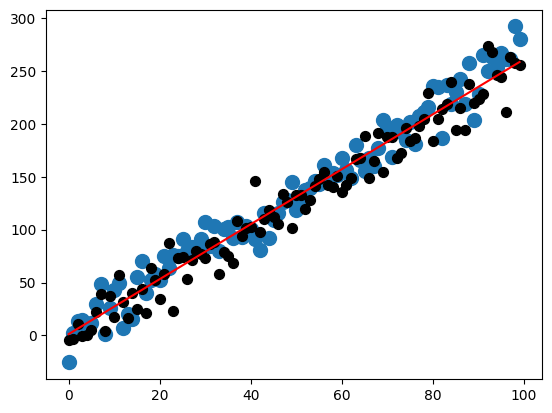

In [11]:
sample_fn = aesara.function((F, Q, H, R, x0, num_step), (Y_rv, X_rv), updates=updates)

y_val, x_val = sample_fn(
    np.asarray([[1.0, 1.0], [0.0, 1.0]]),
    np.zeros([2, 2]),
    np.asarray([[1.0, 0.0]]),
    np.asarray([[sigma_true**2]]),
    np.asarray([theta0, theta1]),
    num_timesteps,
)
_, ax = plt.subplots()
ax.scatter(x, y_val, 100)
ax.scatter(x, y, 50, color="k")
ax.plot(x, yhat, color="r");

In [12]:
# Y_vv = Y_rv.clone()
# X_vv = X_rv.clone()
# x0_vv = x0.clone()

# aeppl.factorized_joint_logprob(
#     {
#         Y_rv: Y_vv,
#         X_rv: X_vv,
#         x0: x0_vv,
#     }
# )

In [13]:
# rv = at.random.multivariate_normal(mu0, sigma0, name="x")
seeded_f = pm.aesaraf.compile_pymc(inputs=[mu0, sigma0], outputs=x0, random_seed=123)
seeded_f(np.zeros([2]), np.eye(2))

array([-0.58122349, -0.04749923])

In [14]:
seeded_f(np.zeros([2]), np.eye(2))

array([-0.11145206,  0.16651069])

In [15]:
logp = aeppl.logprob(x0, at.as_tensor(np.asarray([theta0, theta1])))
logp_fn = aesara.function([mu0, sigma0], logp)
logp_fn(np.zeros([2]), np.eye(2))

array(-5.93787707)

In [16]:
x0_vv = x0.clone()

values = {
    mu0: np.zeros([2]),
    sigma0: np.eye(2),
    x0_vv: np.asarray([theta0, theta1]),
}
logp = aeppl.joint_logprob({x0: x0_vv})
logprob_fn = aesara.function(
    inputs=list(values.keys()),
    outputs=logp,
)
# logprob_fn = pm.aesaraf.compile_pymc(inputs=list(values.keys()), outputs=logp, random_seed=123)
logprob_fn(*values.values())

array(-5.93787707)

In [17]:
# y_vv = Y_rv.clone()
# x_vv = X_rv.clone()
# x0_vv = x0.clone()

# logp = aeppl.joint_logprob({Y_rv: y_vv, X_rv: x_vv, x0: x0_vv})

# values = {
#     y_vv: y,
#     x_vv: x_val,
#     mu0: np.zeros([2]),
#     sigma0: np.eye(2),
#     x0_vv: np.asarray([theta0, theta1]),
#     F: np.asarray([[1.0, 1.0], [0.0, 1.0]]),
#     Q: np.zeros([2, 2]),
#     H: np.asarray([[1.0, 0.0]]),
#     R: np.asarray([[sigma_true**2]]),
#     num_step: num_timesteps,
# }

# logprob_fn = aesara.function(
#     inputs=list(values.keys()), outputs=logp, updates=updates, on_unused_input="ignore"
# )
# # logprob_fn = pm.aesaraf.compile_pymc(inputs=list(values.keys()), outputs=logp, random_seed=123)
# logprob_fn(*values.values())

## Kalman filter

In [18]:
def kalman_filter_onestep(y_t_val, mu_t_tm1, P_t_tm1, Ft, Qt, Ht, Rt):
    # observation
    y_hat_t = Ht @ mu_t_tm1
    St = Ht @ P_t_tm1 @ Ht.T + Rt
    Y_t = srng.multivariate_normal(y_hat_t, St, name="Y_t")
    Y_t_logp = aeppl.logprob(Y_t, y_t_val)
    Y_t_logp.name = "log(Y_t=y_t)"

    # Optimal Kalman gain K_t
    Kt = P_t_tm1 @ Ht.T @ (St**-1)
    mu_t_t = mu_t_tm1 + Kt @ (y_t_val - y_hat_t)
    # P* = P - K * H * P
    P_t_t = P_t_tm1 - Kt @ Ht @ P_t_tm1
    # P_t_t = P_t_tm1 - K_t @ S_t @ K_t.T
    mu_tp1_t = Ft @ mu_t_t
    P_tp1_t = Ft @ P_t_t @ Ft.T + Qt
    return mu_tp1_t, P_tp1_t, y_hat_t, Y_t_logp

In [19]:
# scan over time
(mut, Pt, y_hat_t, Y_t_logp), updates = aesara.scan(
    fn=kalman_filter_onestep,
    sequences=[at.as_tensor(y)],
    outputs_info=[mu0, sigma0, None, None],
    non_sequences=[F, Q, H, R],
    n_steps=num_step,
    # strict=True,
    name="scan_rv",
)
mut.name = "mut"
Pt.name = "Pt"
y_hat_t.name = "y_hat_t"
Y_t_logp.name = "Y_t_logp"

In [20]:
sample_fn = aesara.function(
    [F, Q, H, R, mu0, sigma0, num_step], [mut, Pt, y_hat_t, Y_t_logp], updates=updates
)

mt_filtered, Pt_filtered, observation_means, logp_all = sample_fn(
    np.asarray([[1.0, 1.0], [0.0, 1.0]]),
    np.zeros([2, 2]),
    np.asarray([[1.0, 0.0]]),
    np.asarray([[sigma_true**2]]),
    np.zeros([2]),
    np.eye(2) * 10.0,
    num_timesteps,
)

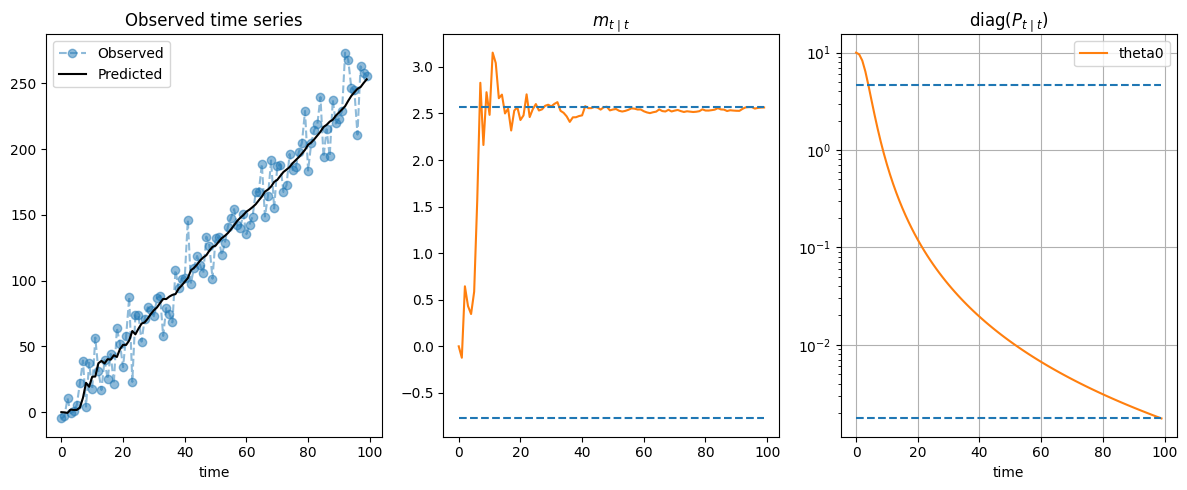

In [21]:
filtered_vars = np.diagonal(Pt_filtered, axis1=1, axis2=2)

_, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].plot(x, y, "--o", alpha=0.5)
ax[0].plot(x, observation_means, lw=1.5, color="k")
ax[0].set_title("Observed time series")
ax[0].legend(["Observed", "Predicted"])
ax[0].set_xlabel("time")

color = ["C4", "C1"]
for i in range(1, 2):
    ax[1].plot(x, mt_filtered[..., i].T, color=color[i])
    ax[2].semilogy(x, filtered_vars[..., i].T, color=color[i])
for i in range(1, 2):
    ax[i + 1].set_xlabel("time")
    ax[i + 1].legend(["theta0", "theta1"])

ax[1].hlines(m_t, x[0], x[-1], ls="--")
ax[1].set_title(r"$m_{t \mid t}$")
ax[2].hlines(np.diagonal(P_t), x[0], x[-1], ls="--")
ax[2].set_title(r"diag($P_{t \mid t}$)")
ax[2].grid()
plt.tight_layout();

In [22]:
H_all = at.concatenate([at.ones((num_timesteps, 1)), at.as_tensor(x)], axis=-1)[..., None, :]
H_all[0].eval().shape

(1, 2)

In [23]:
# scan over time
def step_func(y_t_val, Ht, mu_t_tm1, P_t_tm1, Ft, Qt, Rt):
    return kalman_filter_onestep(y_t_val, mu_t_tm1, P_t_tm1, Ft, Qt, Ht, Rt)


(mut, Pt, y_hat_t, Y_t_logp), updates = aesara.scan(
    fn=step_func,
    sequences=[at.as_tensor(y), H_all],
    outputs_info=[mu0, sigma0, None, None],
    non_sequences=[F, Q, R],
    n_steps=num_step,
    # strict=True,
    name="scan_rv",
)
mut.name = "mut"
Pt.name = "Pt"
y_hat_t.name = "y_hat_t"
Y_t_logp.name = "Y_t_logp"

In [24]:
sample_fn = aesara.function(
    [F, Q, R, mu0, sigma0, num_step], [mut, Pt, y_hat_t, Y_t_logp], updates=updates
)

mt_filtered2, Pt_filtered2, observation_means2, logp_all2 = sample_fn(
    np.eye(2),
    np.zeros([2, 2]),
    np.asarray([[sigma_true**2]]),
    np.zeros([2]),
    np.eye(2) * 10.0,
    num_timesteps,
)

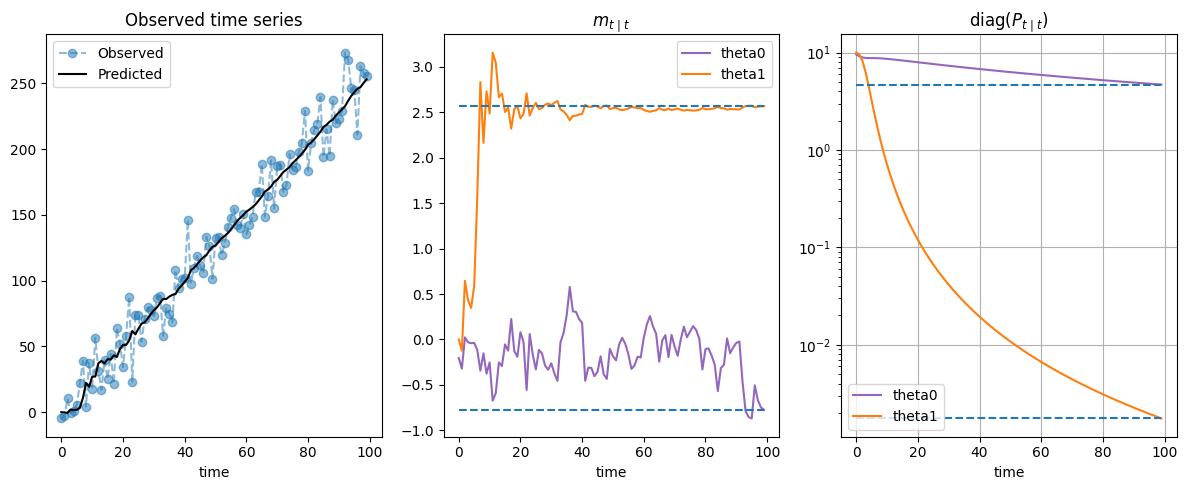

In [25]:
filtered_vars2 = np.diagonal(Pt_filtered2, axis1=1, axis2=2)

_, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].plot(x, y, "--o", alpha=0.5)
ax[0].plot(x, observation_means2, lw=1.5, color="k")
ax[0].set_title("Observed time series")
ax[0].legend(["Observed", "Predicted"])
ax[0].set_xlabel("time")

color = ["C4", "C1"]
for i in range(2):
    ax[1].plot(x, mt_filtered2[..., i].T, color=color[i])
    ax[2].semilogy(x, filtered_vars2[..., i].T, color=color[i])
for i in range(2):
    ax[i + 1].set_xlabel("time")
    ax[i + 1].legend(["theta0", "theta1"])

ax[1].hlines(m_t, x[0], x[-1], ls="--")
ax[1].set_title(r"$m_{t \mid t}$")
ax[2].hlines(np.diagonal(P_t), x[0], x[-1], ls="--")
ax[2].set_title(r"diag($P_{t \mid t}$)")
ax[2].grid()
plt.tight_layout();

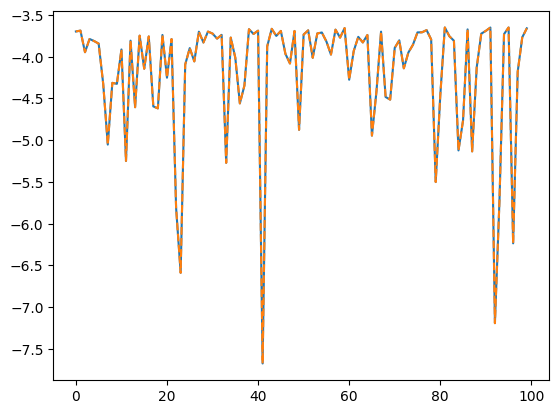

In [26]:
plt.plot(logp_all)
plt.plot(logp_all2, ls="--")

# Using in a PyMC model

In [27]:
with pm.Model(coords={"timestep": np.arange(num_timesteps)}) as m:
    sigma = pm.HalfNormal("sigma", 10.0)
    x0 = pm.Normal("x0", 0.0, 10.0, shape=2)
    # scan over time
    (Y_rv, X_rv), updates = aesara.scan(
        fn=state_space_onestep,
        non_sequences=[
            np.asarray([[1.0, 1.0], [0.0, 1.0]]),
            np.zeros([2, 2]),
            np.asarray([[1.0, 0.0]]),
            sigma[None, None] ** 2,
        ],
        outputs_info=[None, x0],
        n_steps=num_timesteps,
    )
    m.register_rv(X_rv, name="X_rv", initval="prior", dims="timestep")
    m.register_rv(Y_rv, name="Y_rv", data=y)

In [28]:
with m:
    idata = pm.sample_prior_predictive()

Sampling: [X_rv, Y_rv, sigma, x0]


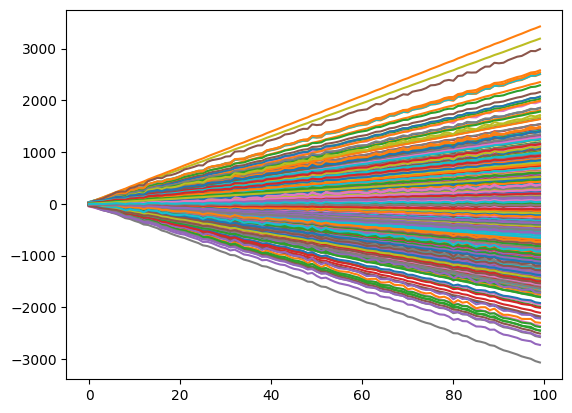

In [29]:
plt.plot(idata.prior_predictive["Y_rv"].squeeze().T);

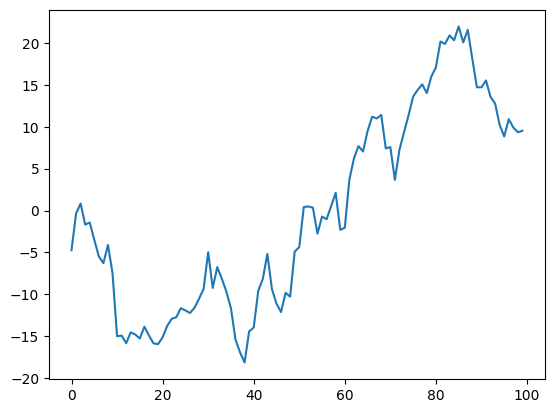

In [30]:
data = np.random.normal(0, 2.5, size=num_timesteps).cumsum()
plt.plot(data);

In [31]:
with pm.Model(coords={"timestep": np.arange(num_timesteps)}) as m:
    sigma = pm.HalfNormal("sigma", 5.0)
    mu = pm.Normal("mu", 0.0, 1.0)

    def step(x_tm1, sigma):
        x = pm.Normal.dist(x_tm1, sigma)
        # x = at.random.normal(x_tm1, sigma)
        # Return the new variable and the RNG update expression
        return x, {x.owner.inputs[0]: x.owner.outputs[0]}

    X_rv, updates = aesara.scan(
        fn=step, outputs_info=[mu], non_sequences=[sigma], n_steps=num_timesteps
    )
    m.register_rv(X_rv, name="X_rv", data=data)
    # X_rv = pm.GaussianRandomWalk("X_rv", mu, sigma, observed=data)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
